In [8]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from operator import itemgetter
import lightgbm as lgb
import time
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_column',100)
pd.set_option('display.max_row',200)

PoolQC 	,
MiscFeature,
Alley ,
Fence 	,
FireplaceQu

In [9]:
df = pd.read_csv('./boston/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [10]:
def fillNaN(df):
    df["PoolQC"] = df["PoolQC"].fillna("None")
    df["MiscFeature"] = df["MiscFeature"].fillna("None")
    df["Alley"] = df["Alley"].fillna("None")
    df["Fence"] = df["Fence"].fillna("None")
    df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
    df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].mean())
    df["Exterior1st"] = df["Exterior1st"].fillna(df["Exterior1st"].mode()[0])
    df["Exterior2nd"] = df["Exterior2nd"].fillna(df["Exterior2nd"].mode()[0])
    df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])
    df["SaleType"] = df["SaleType"].fillna(df["SaleType"].mode()[0])
    df["Functional"] = df["Functional"].fillna(df["Functional"].mode()[0])
    df["KitchenQual"] = df["KitchenQual"].fillna(df["KitchenQual"].mode()[0])
    df["Utilities"] = df["Utilities"].fillna(df["Utilities"].mode()[0])
    df["MSZoning"] = df["MSZoning"].fillna(df["MSZoning"].mode()[0])
    df["GarageType"] = df["GarageType"].fillna("None")
    df["GarageCars"] = df["GarageCars"].fillna(1)
    df["GarageArea"] = df["GarageArea"].fillna(df[df["GarageCars"] == 1]["GarageArea"].mean())
    df["GarageQual"] = df["GarageQual"].fillna("None")
    df["GarageCond"] = df["GarageCond"].fillna("None")
    df["GarageFinish"] = df["GarageFinish"].fillna("None") 
    df.loc[df['GarageYrBlt'].isna(),'GarageYrBlt'] = df.loc[df['GarageYrBlt'].isna()]['YearBuilt']
    df.loc[(df['BsmtQual'].isnull())&(df['BsmtCond'].notnull()),'BsmtQual'] = df['BsmtQual'].mode().iloc[0]
    df.loc[(df['BsmtQual'].notnull())&(df['BsmtCond'].isnull()),'BsmtCond'] = df['BsmtCond'].mode().iloc[0]
    df.loc[(df['BsmtQual'].notnull())&(df['BsmtExposure'].isnull()),'BsmtExposure'] = df['BsmtExposure'].mode().iloc[0]
    df.loc[(df['BsmtQual'].isnull())&(df['BsmtCond'].isnull()),'BsmtQual'] = "None"
    df.loc[(df['BsmtQual'].isnull())&(df['BsmtCond'].isnull()),'BsmtCond'] = "None"
    df.loc[(df['BsmtQual'].isnull())&(df['BsmtExposure'].isnull()),'BsmtExposure'] = "None"
    df["BsmtFinType1"] = df["BsmtFinType1"].fillna("None")
    df["BsmtFinType2"] = df["BsmtFinType2"].fillna("None")
    df["BsmtFinSF1"] = df["BsmtFinSF1"].fillna(0)
    df["BsmtFinSF2"] = df["BsmtFinSF2"].fillna(0)
    df["TotalBsmtSF"] = df["TotalBsmtSF"].fillna(0)
    df["BsmtFullBath"] = df["BsmtFullBath"].fillna(0)
    df["BsmtHalfBath"] = df["BsmtHalfBath"].fillna(0)
    df["BsmtUnfSF"] = df["BsmtUnfSF"].fillna(0)
    df["MasVnrType"] = df["MasVnrType"].fillna("None")
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
    df.fillna("None", inplace=True)
    df["Total_bath"] = df['FullBath'] + (0.5* df["HalfBath"]) + (df["BsmtFullBath"]) + df["BsmtHalfBath"]
    df["Total_floor"] = df["1stFlrSF"] + df["2ndFlrSF"]
    df["totalbsmtFinSF1"] = df["BsmtFinSF1"] + df["BsmtFinSF2"]
    df["Total_room"] = df["TotRmsAbvGrd"] + df["FullBath"] + df["HalfBath"]
    df["avg_sf"] = df["GrLivArea"] / (df["Total_room"] + df["KitchenAbvGr"])
    df["overall"] = df["OverallQual"] + df["OverallCond"]
    ExterQual_dict = {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1}
    BsmtQual_dict = {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1}
    HeatingQC_dict = {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1}
    KitchenQual_dict = {"Ex":4,"Gd":3,"TA":2,"Fa":1}
    GarageQual_dict = {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1}
    return df

In [11]:
test = pd.read_csv('./boston/test.csv')

In [12]:
train , test = fillNaN(df), fillNaN(test)

In [13]:
print(df.shape, test.shape)
df.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',],axis=1, inplace=True)
test.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1, inplace=True)
print(df.shape, test.shape)

(1460, 87) (1459, 86)
(1460, 82) (1459, 81)


In [14]:
df.shape, test.shape

((1460, 82), (1459, 81))

In [15]:
# df = df[(df['LotArea']<200000)&(df['LotFrontage']<300)]
# test = test[(test['LotArea']<200000)&(test['LotFrontage']<300)]

In [16]:
df.shape, test.shape

((1460, 82), (1459, 81))

In [17]:
df['MSSubClass'] = df['MSSubClass'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [18]:
cate_cols = df.select_dtypes(include='O').columns.tolist()

In [19]:
for c in cate_cols:
    df[c] = df[c].astype('category')
    test[c] = test[c].astype('category')

In [20]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_bath,Total_floor,totalbsmtFinSF1,Total_room,avg_sf,overall
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,3.5,1710,706,11,142.500000,12
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,3.0,1262,978,8,140.222222,14
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,3.5,1786,486,9,178.600000,12
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,2.0,1717,216,8,190.777778,12
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,3.5,2198,655,12,169.076923,13


In [21]:
cols_togo = df.drop(['Id','SalePrice'],axis=1).columns
X_tr = df[cols_togo]
X_te = test[cols_togo]
train_Y = df['SalePrice']

In [22]:
def LGB_STRATAKFOLD_REG(fold_num, train_X, test_X, metric, BY, parameters):
    n_fold = fold_num
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

    oof_lgb = np.zeros(len(train_X))
    predictions = np.zeros(len(test_X))
    feature_importance_df = pd.DataFrame()
    cv_score_df = []

    # Model parameters
    lgb_params = parameters

    model_start = time.time()
    model_list = []
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X, BY)):
        strLog = "fold {}".format(fold_)
        print(strLog+ "-" * 50)

        X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
        y_tr, y_val = train_Y.iloc[trn_idx], train_Y.iloc[val_idx]

        model = lgb.LGBMRegressor(**lgb_params, n_jobs = -1)
        model.fit(X_tr, 
                  y_tr, 
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], 
                  eval_metric=metric,
                  verbose=-1, 
                  early_stopping_rounds=500)
        oof_lgb[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)

        cv_score_df.append(model.best_score_)

        #feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = train_X.columns
        fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns)]
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        #predictions
        predictions += model.predict(test_X, num_iteration=model.best_iteration_) / folds.n_splits
        model_list.append(model)
        
    if metric == 'mae':
        result_metric = 'l1'
    elif metric == 'mse':
        result_metric = 'l2'
    elif metric == 'rmse':
        result_metric = 'rmse'
    cv_score_df = pd.DataFrame.from_dict(cv_score_df)
    cv_score_df = cv_score_df.valid_1.tolist()
    cv_score_df = list(map(itemgetter('{}'.format(result_metric)),cv_score_df))

    print("-" * 50)
    
    print("\nMean {} = {}".format(result_metric, np.mean(cv_score_df)))
    print("Std  {}  = {}\n".format(result_metric, np.std(cv_score_df)))
    for i,model in enumerate(model_list):
        lgb.plot_metric(model, metric=result_metric, title='model {}-th {} plot'.format(i+1,result_metric), 
                        xlabel='Iterations', ylabel='',figsize=(4,2), grid=False)
    
    model_end = time.time()
    model_elapsed = model_end - model_start
    print('Model elapsed {0:0.2f}'.format(model_elapsed/60), "minutes.\n")

    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:200].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    pd.set_option('display.max_rows', 500)
    best_features = best_features.drop(['fold'],axis=1)
    best_features = best_features.groupby(['Feature'], as_index = False).mean()
    best_features['Feature Rank'] = best_features['importance'].rank(ascending=0)
    best_features = best_features.sort_values('Feature Rank', ascending = True)
    print(best_features.loc[best_features['importance']!=0].head(50))
    return predictions, oof_lgb, np.mean(cv_score_df), np.std(cv_score_df), best_features

fold 0--------------------------------------------------
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[2647]	training's rmse: 9549.69	valid_1's rmse: 26131.7
fold 1--------------------------------------------------
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[20000]	training's rmse: 1110.77	valid_1's rmse: 23964.8
fold 2--------------------------------------------------
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-

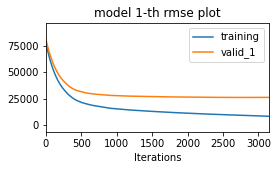

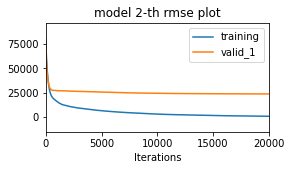

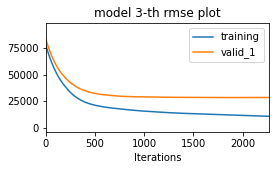

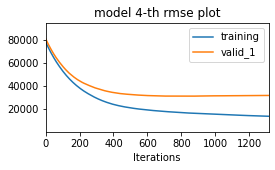

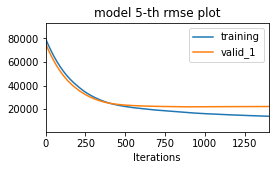

In [24]:
metric = 'rmse'
params = {
#                  'num_leaves': 31,
#                  'min_data_in_leaf': 20, 
                 'objective': metric, # loss
                 'max_depth': 10,
                 'learning_rate': 0.005,
                 "boosting": "gbdt",
#                  "feature_fraction": 1,
#                  "bagging_freq": 1,
#                  "bagging_fraction": 1,
#                  "bagging_seed": 42,
                 "metric": metric,
#                  "lambda_l1": 0.0,
                 "verbosity": -1,
                 "nthread": -1,
                 "random_state": 42,
                'n_estimators': 20000, # num_iterations 
                }

preds, oof, cv_mean, cv_std, best_feats = LGB_STRATAKFOLD_REG(5, X_tr, X_te, metric, X_tr['MoSold'], params)

In [25]:
sub = pd.read_csv("./boston/sample_submission.csv")
sub.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [26]:
sub.shape, len(preds)

((1459, 2), 1459)

In [27]:
sub['SalePrice'] = preds

In [28]:
ctime = datetime.now().strftime("%Hh-%Mm-%Ss")
ctime

'22h-00m-38s'

In [29]:
sub.to_csv('./boston/drop-over40-skf5_{}.csv'.format(ctime), index=False)

## 0.13521

# KFOLD

In [ ]:
from sklearn.model_selection import KFold
def LGB_KFOLD_REG(fold_num, train_X, test_X, metric, params):
    n_fold = fold_num
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

    oof_lgb = np.zeros(len(train_X))
    predictions = np.zeros(len(test_X))
    feature_importance_df = pd.DataFrame()
    cv_score_df = []
    model_list = []
    # Model parameters
    params = {
#                 'num_leaves': 31,
#                  'min_data_in_leaf': 20, 
                 'objective':'regression',
                 'max_depth': -1,
                 'learning_rate': 0.1,
                 "boosting": "gbdt",
                 "feature_fraction": 1,
                 "bagging_freq": 1,
                 "bagging_fraction": 1,
                 "bagging_seed": 42,
                 "metric": metric,
                 "lambda_l1": 0.0,
                 "verbosity": -1,
                 "nthread": -1,
                 "random_state": 42}

    model_start = time.time()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X)):
        strLog = "fold {}".format(fold_)
        print(strLog+ "-" * 50)

        X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
        y_tr, y_val = train_Y.iloc[trn_idx], train_Y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, n_estimators = 200000, n_jobs = -1)
        model.fit(X_tr, 
                  y_tr, 
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], 
                  eval_metric=metric,
                  verbose=-1, 
                  early_stopping_rounds=500)
        oof_lgb[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)

        cv_score_df.append(model.best_score_)

        #feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = train_X.columns
        fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns)]
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        #predictions
        predictions += model.predict(test_X, num_iteration=model.best_iteration_) / folds.n_splits
        model_list.append(model)
        
    if metric == 'mae':
        result_metric = 'l1'
    elif metric == 'mse':
        result_metric = 'l2'
    elif metric == 'rmse':
        result_metric = 'rmse'
        
    cv_score_df = pd.DataFrame.from_dict(cv_score_df)
    cv_score_df = cv_score_df.valid_1.tolist()
    cv_score_df = list(map(itemgetter('rmse'),cv_score_df))

    print("-" * 50)
    print("Mean RMSE = {}".format(np.mean(cv_score_df)))
    print("Std  RMSE  = {}".format(np.std(cv_score_df)))
    for i,model in enumerate(model_list):
        lgb.plot_metric(model, metric=result_metric, title='model {}-th {} plot'.format(i+1,result_metric), 
                        xlabel='Iterations', ylabel='',figsize=(4,2), grid=False)

    model_end = time.time()
    model_elapsed = model_end - model_start
    print('Model elapsed {0:0.2f}'.format(model_elapsed/60), "minutes.")

    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:200].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    pd.set_option('display.max_rows', 500)
    best_features = best_features.drop(['fold'],axis=1)
    best_features = best_features.groupby(['Feature'], as_index = False).mean()
    best_features['Feature Rank'] = best_features['importance'].rank(ascending=0)
    best_features = best_features.sort_values('Feature Rank', ascending = True)
    print(best_features.loc[best_features['importance']!=0].head(50))
    return predictions, oof_lgb, np.mean(cv_score_df), np.std(cv_score_df), best_features

In [ ]:
metric = 'rmse'
params = {
#                  'num_leaves': 31,
#                  'min_data_in_leaf': 20, 
                 'objective': metric, # loss
                 'max_depth': -1,
                 'learning_rate': 0.005,
                 "boosting": "gbdt",
#                  "feature_fraction": 1,
#                  "bagging_freq": 1,
#                  "bagging_fraction": 1,
#                  "bagging_seed": 42,
                 "metric": metric,
#                  "lambda_l1": 0.0,
                 "verbosity": -1,
                 "nthread": -1,
                 "random_state": 42,
                'n_estimators': 50000, # num_iterations 
                }

preds, oof, cv_mean, cv_std, best_feats = LGB_KFOLD_REG(5, X_tr, X_te, metric, params)

In [ ]:
preds

In [ ]:
preds

In [ ]:
sub = pd.read_csv("./boston/sample_submission.csv")
sub.head()

In [ ]:
sub.shape, len(preds)

In [ ]:
sub['SalePrice'] = preds

In [ ]:
ctime = datetime.now().strftime("%Hh-%Mm-%Ss")
ctime

In [ ]:
sub.to_csv('./boston/outlier-kf10_{}.csv'.format(ctime), index=False)